# Lab | LangChain Med

## Objectives

- continue on with lesson 2' example, use different datasets to test what we did in class. Some datasets are suggested in the notebook but feel free to scout other datasets on HuggingFace or Kaggle.
- Find another model on Hugging Face and compare it.
- Modify the prompt to fit your selected dataset.

In [1]:
import numpy as np 
import pandas as pd

## Load the Dataset
As you can see the notebook is ready to work with three different Datasets. Just uncomment the lines of the Dataset you want to use. 

I selected Datasets with News. Two of them have just a brief decription of the news, but the other contains the full text. 

As we are working in a free and limited space, I limited the number of news to use with the variable MAX_NEWS. Feel free to pull more if you have memory available. 

The name of the field containing the text of the new is stored in the variable *DOCUMENT* and the metadata in *TOPIC*

In [3]:
# news = pd.read_csv('/kaggle/input/topic-labeled-news-dataset/labelled_newscatcher_dataset.csv', sep=';')
# MAX_NEWS = 1000
# DOCUMENT="title"
# TOPIC="topic"

#news = pd.read_csv('/kaggle/input/bbc-news/bbc_news.csv')
#MAX_NEWS = 1000
#DOCUMENT="description"
#TOPIC="title"

#news = pd.read_csv('/kaggle/input/mit-ai-news-published-till-2023/articles.csv')
#MAX_NEWS = 100
#DOCUMENT="Article Body"
#TOPIC="Article Header"

news = pd.read_csv('datasets/bbc_news.csv')

MAX_NEWS = 1000
DOCUMENT = "description"
TOPIC = "title"

ChromaDB requires that the data has a unique identifier. We can make it with this statement, which will create a new column called **Id**.


In [4]:
news["id"] = news.index
news.head()

,title,pubDate,guid,link,description,id
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,0
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",1
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,2
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,3
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,4


In [5]:
#Because it is just a course we select a small portion of News.
subset_news = news.head(MAX_NEWS)

## Import and configure the Vector Database
I'm going to use ChromaDB, the most popular OpenSource embedding Database. 

First we need to import ChromaDB, and after that import the **Settings** class from **chromadb.config** module. This class allows us to change the setting for the ChromaDB system, and customize its behavior. 

In [6]:
!pip install chromadb

In [7]:
import chromadb
from chromadb.config import Settings

Now we need to create the seetings object calling the **Settings** function imported previously. We store the object in the variable **settings_chroma**.

Is necessary to inform two parameters 
* chroma_db_impl. Here we specify the database implementation and the format how store the data. I choose ***duckdb***, because his high-performace. It operate primarly in memory. And is fully compatible with SQL. The store format ***parquet*** is good for tabular data. With good compression rates and performance. 

* persist_directory: It just contains the directory where the data will be stored. Is possible work without a directory and the data will be stored in memory without persistece, but Kaggle dosn't support that. 

In [10]:
import chromadb

chroma_client = chromadb.Client()


## Filling and Querying the ChromaDB Database
The Data in ChromaDB is stored in collections. If the collection exist we need to delete it. 

In the next lines, we are creating the collection by calling the ***create_collection*** function in the ***chroma_client*** created above.

In [11]:
collection_name = "news_collection"
if len(chroma_client.list_collections()) > 0 and collection_name in [chroma_client.list_collections()[0].name]:
        chroma_client.delete_collection(name=collection_name)

collection = chroma_client.create_collection(name=collection_name)
    

It's time to add the data to the collection. Using the function ***add*** we need to inform, at least ***documents***, ***metadatas*** and ***ids***. 
* In the **document** we store the big text, it's a different column in each Dataset. 
* In **metadatas**, we can informa a list of topics. 
* In **id** we need to inform an unique identificator for each row. It MUST be unique! I'm creating the ID using the range of MAX_NEWS. 


In [12]:

collection.add(
    documents=subset_news[DOCUMENT].tolist(),
    metadatas=[{TOPIC: topic} for topic in subset_news[TOPIC].tolist()],
    ids=[f"id{x}" for x in range(MAX_NEWS)],
)

/Users/nazb/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:36<00:00, 2.27MiB/s]


In [13]:
results = collection.query(query_texts=["laptop"], n_results=10 )

print(results)

{'ids': [['id775', 'id707', 'id310', 'id587', 'id444', 'id751', 'id701', 'id862', 'id191', 'id740']], 'embeddings': None, 'documents': [['Photography student Thorsten Mjölnir captures the way students decorate their laptops.', 'Why sales of very basic mobile phones, without apps and internet connection, are increasing.', "What do you do when your collection of millions of books keeps growing but your bookshelves don't?", 'The developers of a powerful mini aircraft hope it will be used by the armed forces.', 'How tech is helping young families and couples regain their busy social lives after Covid.', 'Watch as Lee Zii Jia of Malaysia records a speed of 372km/h on his backhand point against Lakshya Sen of India in the All England Badminton Championships.', 'The Royal Mint has found a way to turn old circuit boards from phones, computers and TVs into gold.', 'A van was reportedly hijacked and driven to the venue, and a controlled explosion has since been carried out.', 'The Ukrainian pres

## Vector MAP

In [15]:
!pip install matplotlib
!pip install sklearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 44.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 52.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 14.2 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dep

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [20]:
getado = collection.get(
    ids=[f"id{x}" for x in range(10)],
    include=["documents", "embeddings"]
)

In [21]:
word_vectors = getado["embeddings"]
word_list = getado["documents"]
word_vectors

array([[ 0.03998636,  0.05682722, -0.01463672, ...,  0.02497997,
         0.01154136, -0.07441008],
       [ 0.06657543, -0.01547369, -0.02283252, ..., -0.02888472,
        -0.03599412,  0.02683359],
       [-0.0286562 ,  0.01178944,  0.05725205, ..., -0.05830074,
         0.02858612, -0.01054425],
       ...,
       [-0.04564481, -0.04560341, -0.03863873, ..., -0.0193029 ,
         0.00891603,  0.06896728],
       [ 0.0696163 ,  0.04439398,  0.08648439, ...,  0.00126315,
        -0.04167697,  0.08853965],
       [ 0.04586157,  0.02866877, -0.09951384, ..., -0.08705062,
        -0.06283249,  0.03674906]], shape=(10, 384))

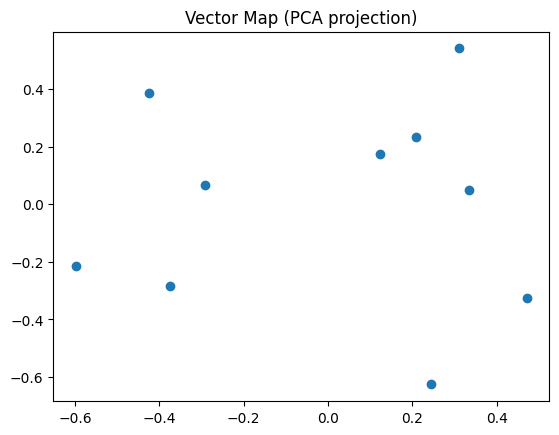

In [22]:
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(word_vectors)

plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
plt.title("Vector Map (PCA projection)")
plt.show()


Once we have our information inside the Database we can query It, and ask for data that matches our needs. The search is done inside the content of the document, and it dosn't look for the exact word, or phrase. The results will be based on the similarity between the search terms and the content of documents. 

The metadata is not used in the search, but they can be utilized for filtering or refining the results after the initial search. 


## Loading the model and creating the prompt
TRANSFORMERS!!
Time to use the library **transformers**, the most famous library from [hugging face](https://huggingface.co/) for working with language models. 

We are importing: 
* **Autotokenizer**: It is a utility class for tokenizing text inputs that are compatible with various pre-trained language models.
* **AutoModelForCasualLLM**: it provides an interface to pre-trained language models specifically designed for language generation tasks using causal language modeling (e.g., GPT models), or the model used in this notebook ***databricks/dolly-v2-3b***.
* **pipeline**: provides a simple interface for performing various natural language processing (NLP) tasks, such as text generation (our case) or text classification. 

The model selected is [dolly-v2-3b](https://huggingface.co/databricks/dolly-v2-3b), the smallest Dolly model. It have 3billion paramaters, more than enough for our sample, and works much better than GPT2. 

Please, feel free to test [different Models](https://huggingface.co/models?pipeline_tag=text-generation&sort=trending), you need to search for NLP models trained for text-generation. My recomendation is choose "small" models, or we will run out of memory in kaggle.  


In [25]:
from dotenv import load_dotenv
import os

load_dotenv()

from huggingface_hub import login
login(token=os.environ["HF_TOKEN"])


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [40]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_id)
lm_model = AutoModelForCausalLM.from_pretrained(model_id)



The next step is to initialize the pipeline using the objects created above. 

The model's response is limited to 256 tokens, for this project I'm not interested in a longer response, but it can easily be extended to whatever length you want.

Setting ***device_map*** to ***auto*** we are instructing the model to automaticaly select the most appropiate device: CPU or GPU for processing the text generation.  

In [44]:
pipe = pipeline(
    "text-generation",
    model=lm_model,
    tokenizer=tokenizer,
    max_new_tokens=64,
    device=-1   
)


Device set to use cpu


## Creating the extended prompt
To create the prompt we use the result from query the Vector Database  and the sentence introduced by the user. 

The prompt have two parts, the **relevant context** that is the information recovered from the database and the **user's question**. 

We only need to join the two parts together to create the prompt that we are going to send to the model. 

You can limit the lenght of the context passed to the model, because we can get some Memory problems with one of the datasets that contains a realy large text in the document part. 

In [45]:
question = "Can I buy a Toshiba laptop?"
context = " ".join([f"#{str(i)}" for i in results["documents"][0]])
context = context[0:5120]
prompt_template = f"Relevant context: {context}\n\n The user's question: {question}"
prompt_template

"Relevant context: #Photography student Thorsten Mjölnir captures the way students decorate their laptops. #Why sales of very basic mobile phones, without apps and internet connection, are increasing. #What do you do when your collection of millions of books keeps growing but your bookshelves don't? #The developers of a powerful mini aircraft hope it will be used by the armed forces. #How tech is helping young families and couples regain their busy social lives after Covid. #Watch as Lee Zii Jia of Malaysia records a speed of 372km/h on his backhand point against Lakshya Sen of India in the All England Badminton Championships. #The Royal Mint has found a way to turn old circuit boards from phones, computers and TVs into gold. #A van was reportedly hijacked and driven to the venue, and a controlled explosion has since been carried out. #The Ukrainian president reveals his location in Kyiv in a new video shared on social media. #The Royal Mint has found a way to turn old circuit boards f

Now all that remains is to send the prompt to the model and wait for its response!


In [46]:
lm_response = pipe(prompt_template)
print(lm_response[0]["generated_text"])

Relevant context: #Photography student Thorsten Mjölnir captures the way students decorate their laptops. #Why sales of very basic mobile phones, without apps and internet connection, are increasing. #What do you do when your collection of millions of books keeps growing but your bookshelves don't? #The developers of a powerful mini aircraft hope it will be used by the armed forces. #How tech is helping young families and couples regain their busy social lives after Covid. #Watch as Lee Zii Jia of Malaysia records a speed of 372km/h on his backhand point against Lakshya Sen of India in the All England Badminton Championships. #The Royal Mint has found a way to turn old circuit boards from phones, computers and TVs into gold. #A van was reportedly hijacked and driven to the venue, and a controlled explosion has since been carried out. #The Ukrainian president reveals his location in Kyiv in a new video shared on social media. #The Royal Mint has found a way to turn old circuit boards fr